In [2]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache
%matplotlib widget

In [3]:
# Paths for data
xsec_path = "../../../data/atmosphere/xsecs"
cia_path = "../../../data/atmosphere/cia/hitran"
phoenix_path = "../../../data/atmosphere/phoenix/BT-Settl_M-0.0a+0.0"

#importing crossections
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(xsec_path)
CIACache().set_cia_path(cia_path)

In [4]:
#(parameters: https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39%20b#planet_WASP-39-b_collapsible)
#Atmospheric model
# Temperature profile
temperature_value = 1166.0  # Kelvin (Teq for isothermal)
#guillot
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=temperature_value) #?????

#isothermal
from taurex.temperature import Isothermal
isothermal = Isothermal(T=temperature_value) #Teq

#Planet
# Planetary parameters
planet_radius = 1.279  # in Jupiter radii
planet_mass = 0.281  # in Jupiter masses
from taurex.planet import Planet
planet = Planet(planet_radius=planet_radius,planet_mass=planet_mass)

#star
# Stellar parameters
star_temperature = 5485  # Kelvin
star_radius = 0.939  # in Solar radii

from taurex.stellar import BlackbodyStar
from taurex.stellar import PhoenixStar
star = BlackbodyStar(temperature=star_temperature,radius=star_radius) #ideal blackbody
anotherstar = PhoenixStar(phoenix_path=phoenix_path,
                          temperature=star_temperature,radius=star_radius) #considering stellar atmosphere

#chemistry
fill_gases = ['H2', 'He']
ratio = 0.172

gas_names = ['H2O', 'CO2', 'CO', 'Na']
#Main components
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=fill_gases,ratio=ratio)


mix_ratio = [1e-3,
             1e-5,
             1e-6,
             1e-6]


print('*************************\n'
    f'Random mixing ratios:\n'
      f'{gas_names[0]}: {mix_ratio[0]:.3e}\n'
      f'{gas_names[1]}: {mix_ratio[1]:.3e}\n'
      f'{gas_names[2]}: {mix_ratio[2]:.3e}\n'
      f'{gas_names[3]}: {mix_ratio[3]:.3e}\n'
      '*************************')

from taurex.chemistry import ConstantGas
h2o = ConstantGas(gas_names[0],mix_ratio=mix_ratio[0])
chemistry.addGas(h2o)
co2 = ConstantGas(gas_names[1],mix_ratio=mix_ratio[1])
chemistry.addGas(co2)
co = ConstantGas(gas_names[2],mix_ratio=mix_ratio[2])
chemistry.addGas(co)
na = ConstantGas(gas_names[3],mix_ratio=mix_ratio[3])
chemistry.addGas(na)

#all toghether
temperature_type = "isothermal"
# Pressure profile
atm_min_pressure = 1e-0  # bar
atm_max_pressure = 1e6  # bar
nlayers = 30

from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=anotherstar,
                       atm_min_pressure=atm_min_pressure,
                       atm_max_pressure=atm_max_pressure,
                       nlayers=nlayers)


# Model type
model_type = "transmission"

#physical phenomena
#absorption
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

#CIA (collisional induced absorption)
from taurex.contributions import CIAContribution
# Contributions
cia_pairs = ['H2-H2', 'H2-He']
tm.add_contribution(CIAContribution(cia_pairs=cia_pairs))

#scattering
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()

#running the model
res = tm.model()

*************************
Random mixing ratios:
H2O: 1.000e-03
CO2: 1.000e-05
CO: 1.000e-06
Na: 1.000e-06
*************************


Lunghezza modello:207
Lunghezza osservazioni:207


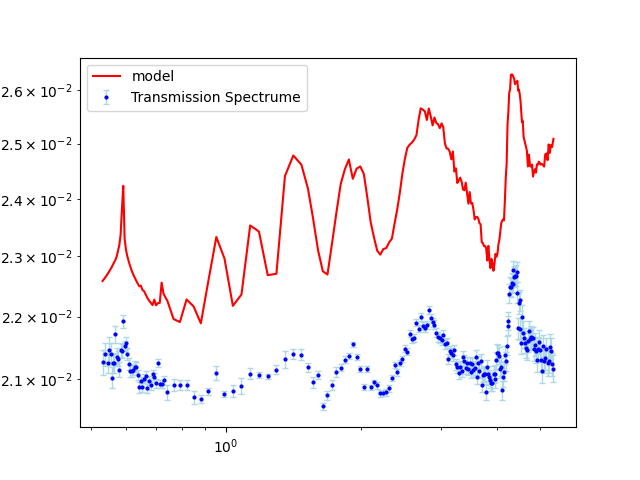

In [5]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('../taskB/WASP-39b_spectrum_assignment3_taskB.dat')


native_grid, rprs, tau, _ = res


from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
# wngrid = np.sort(10000/np.logspace(-0.4, 1.1, 1000))
# bn = SimpleBinner(wngrid=wngrid)

# bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

# Imposta la griglia di lunghezze d'onda del modello sulle lunghezze d'onda delle osservazioni
wngrid_obs = 10000 / obs.wavelengthGrid[::-1]  # Converte lunghezze d'onda in wavenumber (cm^-1)
wngrid_obs = np.sort(wngrid_obs)  # Assicura che la griglia sia ordinata

bn = SimpleBinner(wngrid=wngrid_obs)

# Calcola il modello sulla griglia delle osservazioni
bin_wn, bin_rprs, _, _ = bn.bin_model(tm.model(wngrid=wngrid_obs))


print(f'Lunghezza modello:{len(bin_wn)}')
print(f'Lunghezza osservazioni:{len(obs.wavelengthGrid)}')

plt.errorbar(
    obs.wavelengthGrid, obs.spectrum, obs.errorBar, fmt='o', color='blue', markersize=2,
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrume"
)
plt.plot(10000/bin_wn,bin_rprs,label='model',color='r')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

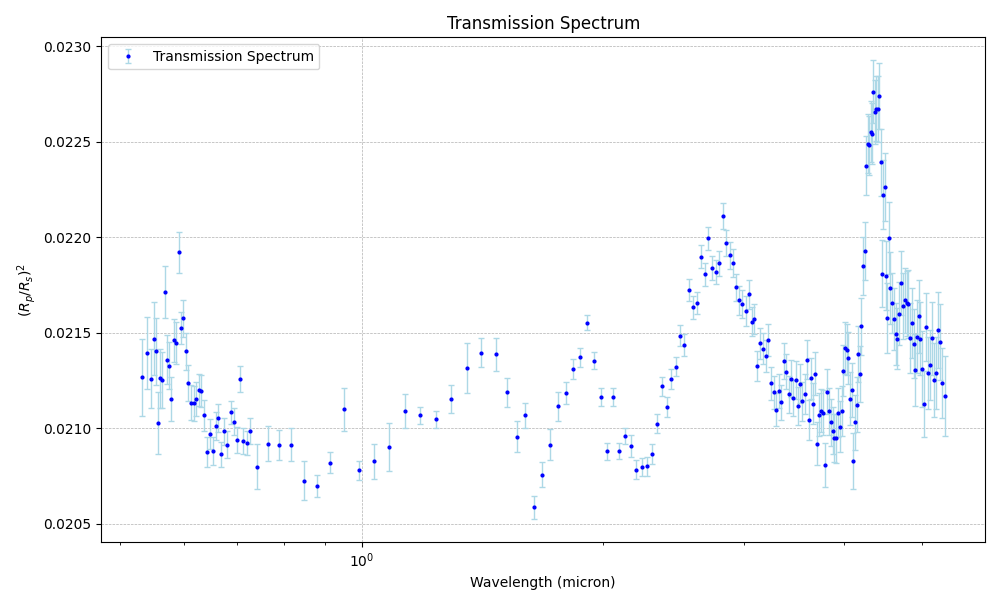

In [6]:
# Plot 
plt.figure(figsize=(10, 6))
plt.errorbar(
    obs.wavelengthGrid, obs.spectrum, obs.errorBar, fmt='o', color='blue', markersize=2,
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum"
)
plt.xlabel("Wavelength (micron)")
plt.ylabel("$(R_p/R_s)^2$")
plt.title("Transmission Spectrum")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.xscale('log')
plt.show()


In [7]:
from taurex.optimizer.nestle import NestleOptimizer

opt = NestleOptimizer(num_live_points=50)

#list of possible parameters that we can retrive from this model
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CO2',
 'CO',
 'Na',
 'He_H2']

In [8]:
#binned for plotting
obin = obs.create_binner()

opt.set_model(tm)
opt.set_observed(obs)

In [9]:
#Choosing the parameters to fit and the boudaries
opt.enable_fit('He_H2')
opt.set_boundary('He_H2',[1e-2,5e-1])
opt.enable_fit('H2O')
opt.set_boundary('H2O',[1e-4,1e-2])
opt.enable_fit('CO2')
opt.set_boundary('CO2',[1e-5,1e-3])
opt.enable_fit('Na')
opt.set_boundary('Na',[1e-7,1e-4])
opt.enable_fit('CO')
opt.set_boundary('CO',[1e-7,1e-4])
opt.enable_fit('T')
opt.set_boundary('T',[1000,2000])
opt.enable_fit('planet_radius')
opt.set_boundary('planet_radius',[0.8,2.0])

In [11]:
#retrival
from taurex.taurexdefs import OutputSize

output_size = OutputSize.heavy
solution = opt.fit(output_size=output_size)

taurex.log.disableLogging()

it=  2768 logz=465.167090733229niter: 2769
ncall: 6685
nsamples: 2819
logz: 465.407 +/-  1.013
h: 51.298


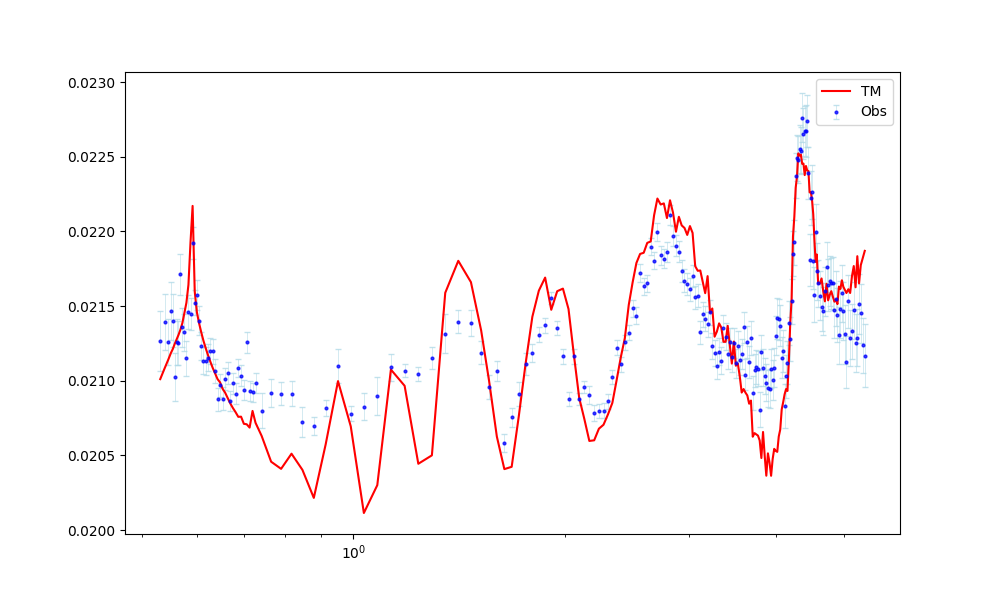

In [19]:
for solution, optimized_map, optimized_value, values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure(figsize=(10,6))
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar, fmt='o', color='blue', markersize=2,
    ecolor='lightblue', elinewidth=0.5, capsize=2, alpha=0.75, label="Obs")
    plt.plot(obs.wavelengthGrid, obin.bin_model(tm.model(obs.wavenumberGrid))[1], color='r', label='TM')
    plt.legend()
    plt.xscale('log')
    plt.savefig('primofit.png')
    plt.show()

In [17]:
for sol_num, optimized_map, median_values, extra in opt.get_solution():
    stats, fitting_params, raw_traces, raw_weights = extra

    # Update model with best-fit parameters
    opt.update_model(optimized_map)

    # Extract observed and best-fit spectrum
    obs_wavelength = obs.wavelengthGrid
    obs_spectrum = obs.spectrum
    obs_error = obs.errorBar
    _, bestfit_spectrum, _, _ = obin.bin_model(tm.model(obs.wavenumberGrid))

    # Extract parameter names
    param_dict = fitting_params[1]
    param_names = list(param_dict.keys())
    print("Parameter Names:", param_names)
    
    for parameter in param_names:
        index = param_names.index(parameter)
        print("MAP estimates:")
        print(f"{parameter}:", optimized_map[index])
        print("Median estimates:")
        print(f"{parameter}:", median_values[index])           


Parameter Names: ['planet_radius', 'T', 'log_H2O', 'log_CO2', 'log_CO', 'log_Na', 'log_He_H2']
MAP estimates:
planet_radius: 1.2405621519777066
Median estimates:
planet_radius: 1.2407480019763375
MAP estimates:
T: 1000.095166319803
Median estimates:
T: 1000.2536942359081
MAP estimates:
log_H2O: -2.5859712010078457
Median estimates:
log_H2O: -2.5914434212093136
MAP estimates:
log_CO2: -4.991739298790935
Median estimates:
log_CO2: -4.992648330936586
MAP estimates:
log_CO: -4.005194220055114
Median estimates:
log_CO: -4.092564620928502
MAP estimates:
log_Na: -4.000015916672222
Median estimates:
log_Na: -4.00345732517424
MAP estimates:
log_He_H2: -0.3017902118659055
Median estimates:
log_He_H2: -0.3016865622891848


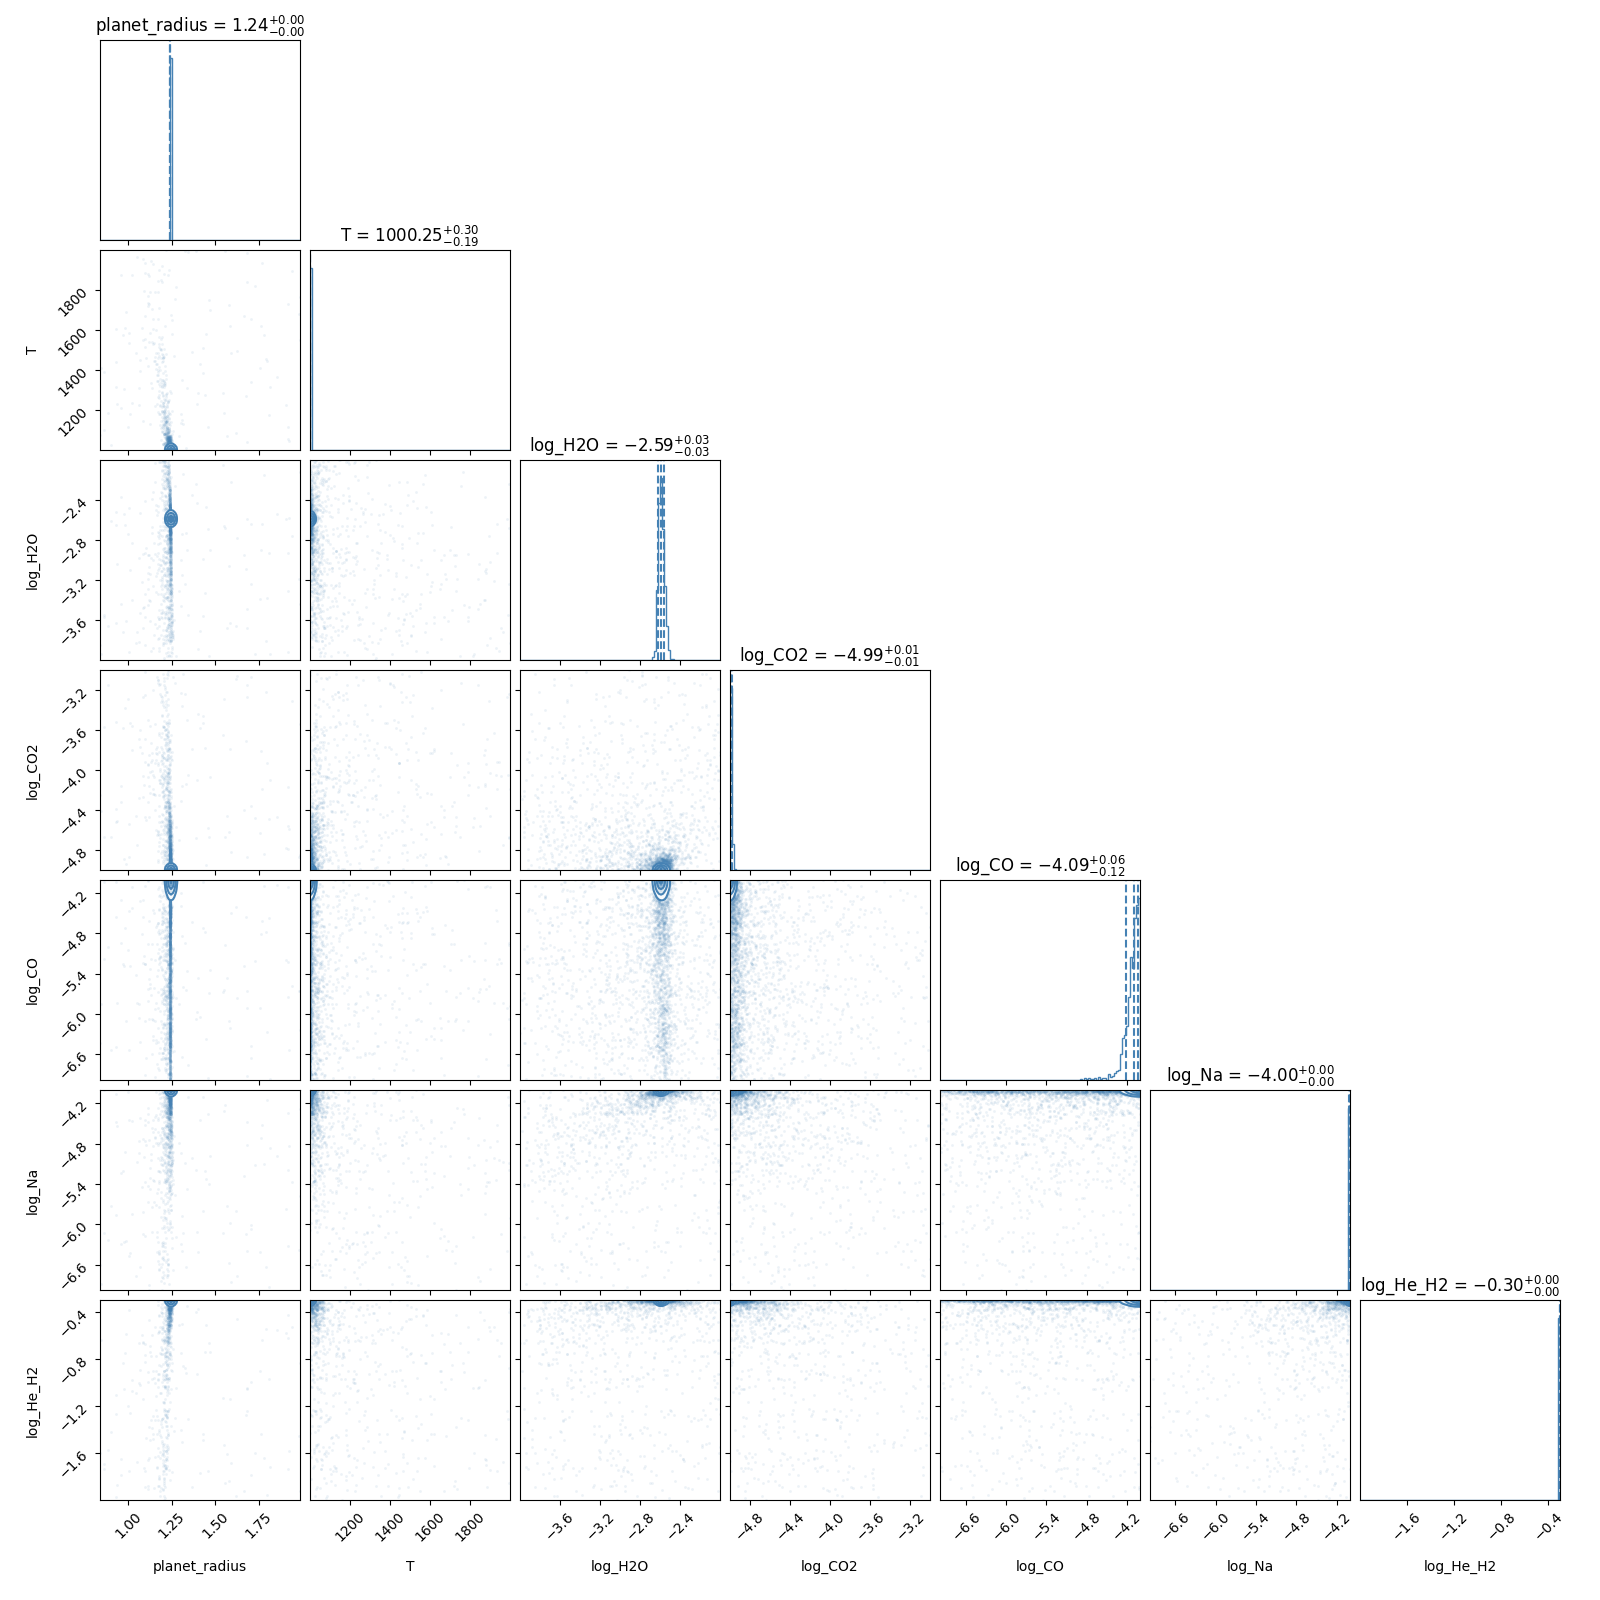

In [18]:
from taurex.plot.corner import corner

# Retrieve samples, weights, and parameter names
samples = opt.get_samples(0)
weights = opt.get_weights(0)
labels = opt.fit_names

# Create the corner plot
fig = corner(
    samples,
    
    weights=weights,
    labels=labels,
    bins=100,
    smooth=1.5,# Parameter names
               # Importance weights
    show_titles=True,          # Display titles with quantiles
    title_fmt=".2f",           # Format for the quantile titles
    quantiles=[0.16, 0.5, 0.84],  # Display the 16th, 50th, and 84th percentiles
    color="#4682b4"               # Color for histograms
)

# Show or save the figure
plt.show()
# Alternatively, save to a file
fig.savefig("taskD_corner_plot.png")